In [1]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import collections
import os
import random
import time
from tqdm import tqdm
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
%matplotlib notebook
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#### 读取csv文件并进行处理

In [2]:
# 读取csv并分离成列表
with open('20200101.export.CSV','r') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        lines[i]= lines[i].split('\n')[0]
        lines[i]= lines[i].split('\t')
        #print(len(line))

In [3]:
# 手动划分标题
title = ['索引','日期','发生年月','发生年','时间节点百分比', # 事件的全局符号🐎 EVENT AND DATE ATTRIBUTES
         '信息码1','参与1名称','参与1国家','参与1组织','参与1民族','参与1宗教','参与1额外宗教','参与1角色','参与1额外角色','参与1额外角色',# 参与者信息 ACTOR ATTRIBUTES 
         '信息码2','参与2名称','参与2国家','参与2组织','参与2民族','参与2宗教','参与2额外宗教','参与2角色','参与2额外角色','参与2额外角色',
         '是否根节点','参与者1对2的行为','三级分类','根节点','事件类型','事件的潜在影响(无细节)','提及次数','数据源','文章数','舆论评分',# 事件的属性 EVENT ACTION ATTRIBUTES
         '参与1Geo类型','参与1地理全称','参与1国家编号','参与1全球编码','参与1纬度','参与1经度','参与1GNS标识',# 地理信息  EVENT GEOGRAPHY
         '参与2Geo类型','参与2地理全称','参与2国家编号','参与2全球编码','参与2纬度','参与2经度','参与2GNS标识',
         '发生地Geo类型','发生地地理全称','发生地国家编号','发生地全球编码','发生地纬度','发生地经度','发生地GNS标识' ,
         '加入数据库的日期','新闻URL' # 信息记录  DATA MANAGEMENT FIELDS
        ]

In [6]:
# 添加列名
csvdata = pd.DataFrame(lines,columns=title) 
csvdata.head()

,索引,日期,发生年月,发生年,时间节点百分比,信息码1,参与1名称,参与1国家,参与1组织,参与1民族,...,参与2GNS标识,发生地Geo类型,发生地地理全称,发生地国家编号,发生地全球编码,发生地纬度,发生地经度,发生地GNS标识,加入数据库的日期,新闻URL
0,896047517,20190101,201901,2019,2019.0027,,,,,,...,509453,2,"Kentucky, United States",US,USKY,37.669,-84.6514,KY,20200101,https://www.whas11.com/article/news/local/man-...
1,896047518,20190101,201901,2019,2019.0027,CAN,CANADA,CAN,,,...,-574764,4,"Thousand Islands, Ontario, Canada",CA,CA08,44.3333,-76,-574764,20200101,https://www.recorder.ca/news/local-news/februa...
2,896047519,20190101,201901,2019,2019.0027,CVL,TOURIST,,,,...,-1603135,4,"Sydney, New South Wales, Australia",AS,AS02,-33.8833,151.217,-1603135,20200101,https://www.smh.com.au/world/europe/not-made-f...
3,896047520,20190101,201901,2019,2019.0027,CYP,CYPRUS,CYP,,,...,-2588872,4,"Aylesbury, Buckinghamshire, United Kingdom",UK,UKB9,51.8167,-0.8,-2588872,20200101,https://www.dailymail.co.uk/debate/article-784...
4,896047521,20190101,201901,2019,2019.0027,ETH,ETHIOPIA,ETH,,,...,,1,Ethiopia,ET,ET,8,38,ET,20200101,https://timesofindia.indiatimes.com/blogs/extr...


In [7]:
csvdata.to_csv('Result.csv') 

In [7]:
# 需要用到的标题
title_in_use = ['日期',
                       '参与1名称','参与1国家','参与1组织','参与1民族','参与1宗教','参与1角色',
                    '参与2名称', '参与2国家','参与2组织','参与2民族','参与2宗教','参与2角色',
                     #'提及次数','文章数',
                '舆论评分']
title_in_use[1:-1]

['参与1名称',
 '参与1国家',
 '参与1组织',
 '参与1民族',
 '参与1宗教',
 '参与1角色',
 '参与2名称',
 '参与2国家',
 '参与2组织',
 '参与2民族',
 '参与2宗教',
 '参与2角色']

In [8]:
data_in_use = csvdata[title_in_use]

In [9]:
data_in_use.head()

,日期,参与1名称,参与1国家,参与1组织,参与1民族,参与1宗教,参与1角色,参与2名称,参与2国家,参与2组织,参与2民族,参与2宗教,参与2角色,舆论评分
0,20190101,,,,,,,UNITED STATES,USA,,,,,0
1,20190101,CANADA,CAN,,,,,LEEDS,GBR,,,,,-0.7164790174002
2,20190101,TOURIST,,,,,CVL,UNITED KINGDOM,GBR,,,,,-0.95238095238095
3,20190101,CYPRUS,CYP,,,,,BRITISH,GBR,,,,,-3.75985445724681
4,20190101,ETHIOPIA,ETH,,,,,,,,,,,-6.20067643742954


In [39]:
data_in_use.to_csv('out2.csv')

统计所有出现的词的个数

In [10]:
# 全都变成小写
for each in title_in_use:
    data_in_use[each] = data_in_use[each].str.lower()

D:\Python\Python36\Lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
data_in_use.head()

,日期,参与1名称,参与1国家,参与1组织,参与1民族,参与1宗教,参与1角色,参与2名称,参与2国家,参与2组织,参与2民族,参与2宗教,参与2角色,舆论评分
0,20190101,,,,,,,united states,usa,,,,,0
1,20190101,canada,can,,,,,leeds,gbr,,,,,-0.7164790174002
2,20190101,tourist,,,,,cvl,united kingdom,gbr,,,,,-0.95238095238095
3,20190101,cyprus,cyp,,,,,british,gbr,,,,,-3.75985445724681
4,20190101,ethiopia,eth,,,,,,,,,,,-6.20067643742954


In [12]:
# 开始进行统计
new_array = np.array(data_in_use[title_in_use[1:-1]])
counter = collections.Counter(new_array.flatten())
len(counter)

2871

In [13]:
vocab = Vocab.Vocab(counter)

In [15]:
vocab['']

2

In [14]:
# 获取特征值和标签
features = []
labels = []
for index, row in data_in_use.iterrows():
    if row['参与1名称']!='' and row['参与2名称']!='':
        # 将前几项编码成数字
        feature = [vocab.stoi[row[each]] for each in title_in_use[1:-1]]
        features.append(feature)
        # 获取打分数值
        label = row["舆论评分"]
        labels.append(1 if float(label) >=0 else 0)

In [15]:
len(features)

54611

In [16]:
# 变成tensor类型
tensor_features = torch.Tensor(features)
tensor_labels = torch.Tensor(labels)

In [18]:
tensor_labels

tensor([0., 0., 0.,  ..., 1., 0., 0.])

In [19]:
collections.Counter(labels)

Counter({0: 41398, 1: 13213})

In [20]:
len(features)

54611

In [21]:
tensor_features.shape

torch.Size([54611, 12])

In [22]:
# 转换成长整型
tensor_features = tensor_features.long()
tensor_labels = tensor_labels.long()

# 1/4切分出训练集和测试集
train_features = tensor_features[:int(0.8*tensor_features.shape[0])]
train_labels = tensor_labels[:int(0.8*tensor_labels.shape[0])]

test_features = tensor_features[int(0.8*tensor_features.shape[0]):]
test_labels = tensor_labels[int(0.8*tensor_labels.shape[0]):]


In [23]:
train_features.shape

torch.Size([43688, 12])

In [24]:
# 建立Dataset
train_set = Data.TensorDataset(train_features, train_labels)
test_set = Data.TensorDataset(test_features, test_labels)

In [25]:
# 新建loader迭代器
batch_size = 64
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
print('#batches:', len(train_iter))

X torch.Size([64, 12]) y torch.Size([64])
#batches: 683


In [63]:
class BiRNN(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers):
        '''
        @params:
            vocab: 在数据集上创建的词典，用于获取词典大小
            embed_size: 嵌入维度大小
            num_hiddens: 隐藏状态维度大小
            num_layers: 隐藏层个数
        '''
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        
        # encoder-decoder framework
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=embed_size, 
                                hidden_size=num_hiddens, 
                                num_layers=num_layers)#,
                                #bidirectional=True)
        self.decoder = nn.Linear(2*num_hiddens, 2) # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        
    def forward(self, inputs):
        '''
        @params:
            inputs: 词语下标序列，形状为 (batch_size, seq_len) 的整数张量
        @return:
            outs: 对文本情感的预测，形状为 (batch_size, 2) 的张量
        '''
        # 因为LSTM需要将序列长度(seq_len)作为第一维，所以需要将输入转置
        embeddings = self.embedding(inputs.permute(1, 0)) # (seq_len, batch_size, d)
        # rnn.LSTM 返回输出、隐藏状态和记忆单元，格式如 outputs, (h, c)
        outputs, _ = self.encoder(embeddings) # (seq_len, batch_size, 2*h)
        encoding = torch.cat((outputs[0], outputs[-1]), -1) # (batch_size, 4*h)
        outs = self.decoder(encoding) # (batch_size, 2)
        return outs

embed_size, num_hiddens, num_layers = 100, 100, 2
net = BiRNN(vocab, embed_size, num_hiddens, num_layers)

In [64]:
# 保存损失等值
loss_list = []
train_acc_list = []
test_acc_list = []

In [65]:
# 计算准确率
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval()
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train()
            else:
                if('is_training' in net.__code__.co_varnames):
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

# 训练
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
           
            y_hat = net(X)
            l = loss(y_hat, y.long()) 
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
            
            loss_list.append(train_l_sum / batch_count)
            train_acc_list.append(train_acc_sum / n)
            #test_acc_list.append(evaluate_accuracy(test_iter, net))
        test_acc = evaluate_accuracy(test_iter, net)
        test_acc_list.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [66]:
lr, num_epochs = 0.01, 10

#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
#optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()

train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.5722, train acc 0.748, test acc 0.779, time 6.1 sec
epoch 2, loss 0.2797, train acc 0.753, test acc 0.779, time 6.3 sec
epoch 3, loss 0.1863, train acc 0.753, test acc 0.779, time 6.0 sec
epoch 4, loss 0.1395, train acc 0.753, test acc 0.779, time 6.6 sec
epoch 5, loss 0.1115, train acc 0.753, test acc 0.779, time 6.0 sec
epoch 6, loss 0.0928, train acc 0.753, test acc 0.779, time 6.1 sec
epoch 7, loss 0.0794, train acc 0.753, test acc 0.779, time 6.2 sec
epoch 8, loss 0.0693, train acc 0.753, test acc 0.779, time 6.1 sec
epoch 9, loss 0.0614, train acc 0.753, test acc 0.779, time 6.1 sec
epoch 10, loss 0.0550, train acc 0.753, test acc 0.779, time 5.9 sec


In [70]:
loss3_list = loss_list

In [69]:
train3_acc_list = train_acc_list

In [ ]:
# Adam
loss1_list
train1_acc_list 

In [ ]:
# RMSProp
loss2_list
train2_acc_list

In [ ]:
# SGD
loss3_list
train3_acc_list

<IPython.core.display.Javascript object>


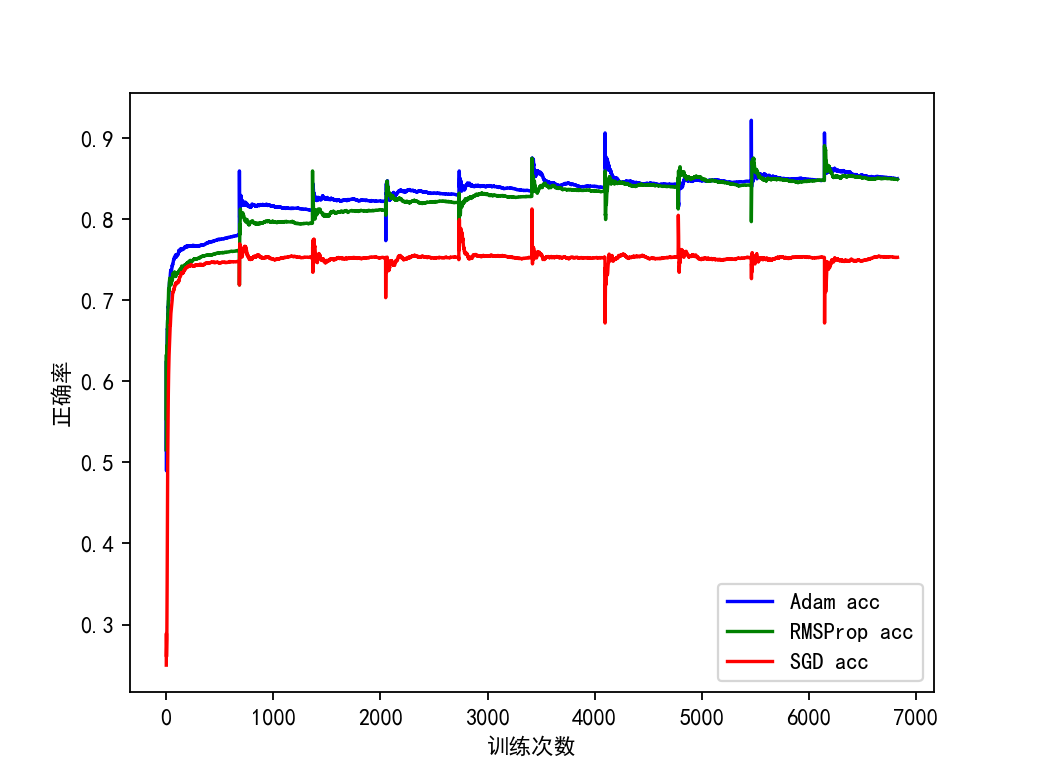

In [86]:
#plt.plot(loss1_list,color="blue",label="Adam loss")
plt.plot(train1_acc_list,color="blue",label="Adam acc")
#plt.plot(loss2_list,color="green",label="RMSProp loss")
plt.plot(train2_acc_list,color="green",label="RMSProp acc")
#plt.plot(loss3_list,color="red",label="SGD loss")
plt.plot(train3_acc_list,color="red",label="SGD acc")
plt.legend(loc="lower right")
plt.xlabel('训练次数')
plt.ylabel('正确率')
plt.savefig ('lala2.png')

In [71]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False